In [64]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from math import factorial
from scipy.linalg import solveh_banded
np.set_printoptions(precision=3, linewidth=200)

In [132]:
def get_points(a, b, n, mode):
    if mode == 'uniform':
        points = np.linspace(a, b, n)
    elif mode == 'random':
        points = np.concatenate(([a], np.sort(np.random.rand(n - 2) * (b - a) + a), [b]))
    elif mode == 'chebyshev':
        points = (np.polynomial.chebyshev.chebpts1(n) + 1) / 2 * (b - a) + a
    else:
        print(f'incorrect mode {mode}')
        points = 0
    return np.array(points)

In [133]:
def plot(splines, f, a, b, spline_points, name):
    #a = a - 1
    #b = b + 1
    plot_points = get_points(a, b, int(1000 * (b - a)), 'uniform')
    plt.plot(plot_points, f(plot_points), color='b', label='function')
    for i, s in enumerate(splines):
        points = plot_points[(plot_points >= spline_points[i]) & (plot_points <= spline_points[i + 1])]
        points_args = (points - points.min()) / (points.max() - points.min())
        plt.plot(points, splines[i](points_args), color='r')
    plt.plot(spline_points, f(spline_points), 'ro')
    plt.title(name)
    plt.legend()
    plt.grid()
    plt.show()

In [145]:
def spline_interpol(n, a, b, f, mode, verbose=False):
    points = get_points(a, b, n + 1, mode)
    h = np.array([points[i] - points[i - 1] for i in range(1, n + 1)])
    fx = f(points)
    matrix = np.zeros((n - 1, n - 1))
    matrix[0][0] = 2 * (h[0] + h[1])
    matrix[0][1] = h[1]
    for i in range(1, n - 2):
        matrix[i][i - 1] = h[i]
        matrix[i][i] = 2 * (h[i] + h[i + 1])
        matrix[i][i + 1] = h[i + 1]
    matrix[n - 2][n - 2] = 2 * (h[n - 2] + h[n - 1])
    matrix[n - 2][n - 3] = h[n - 2]
    deltaf = np.zeros((n))
    for i in range(n):
        deltaf[i] = (fx[i + 1] - fx[i]) / h[i]
    ro = np.zeros((n - 1))
    for i in range(n - 1):
        ro[i] = 6 * (deltaf[i + 1] - deltaf[i])
    matrix_banded = np.vstack((matrix.diagonal(), np.concatenate((matrix.diagonal(1), [0]))))

    if verbose:
        print('p', points)
        print('h', h)
        print('f', fx)
        print('d', deltaf)
        print('r', ro)
        print('matrix')
        print(matrix)
        print(matrix_banded)
    
    u = solveh_banded(matrix_banded, ro, overwrite_ab=True, overwrite_b=True, lower=True, check_finite=False)
    u = np.concatenate(([0], u, [0]))
    if verbose:
        print('u', u, u.shape)

    splines = []
    at = Polynomial([-1/6, 1/6]) - 1/6 * Polynomial.fromroots([1, 1, 1]) #Polynomial.fromroots([0, 1, 2]) / -6
    bt = Polynomial([0, -1/6, 0, 1/6])
    if verbose:
        print('a', at)
        print('b', bt)
    for k in range(n):
        spline = Polynomial([1, -1]) * fx[k] + Polynomial([0, 1]) * fx[k + 1] + u[k] * h[k] * h[k] * at + u[k + 1] * h[k] * h[k] * bt
        if verbose:
            print(k + 1, spline)
        splines.append(spline)
    plot(splines, f, a, b, points, 'spline interpolation ' + mode)

p [0.    4.939 5.425 6.437 9.   ]
h [4.939 0.486 1.012 2.563]
f [ 0.    -0.974 -0.757  0.153  0.412]
d [-0.197  0.448  0.899  0.101]
r [ 3.873  2.705 -4.787]
matrix
[[10.85   0.486  0.   ]
 [ 0.486  2.995  1.012]
 [ 0.     1.012  7.15 ]]
[[10.85   2.995  7.15 ]
 [ 0.486  1.012  0.   ]]
u [ 0.     0.306  1.134 -0.83   0.   ] (5,)
a 0.0 - 0.333 x + 0.5 x**2 - 0.167 x**3
b 0.0 - 0.167 x + 0.0 x**2 + 0.167 x**3
1 0.0 - 2.219 x + 0.0 x**2 + 1.245 x**3
2 -0.974 + 0.149 x + (3.609e-02) x**2 + (3.253e-02) x**3
3 -0.757 + 0.664 x + 0.581 x**2 - 0.335 x**3
4 0.153 + 2.077 x - 2.727 x**2 + 0.909 x**3


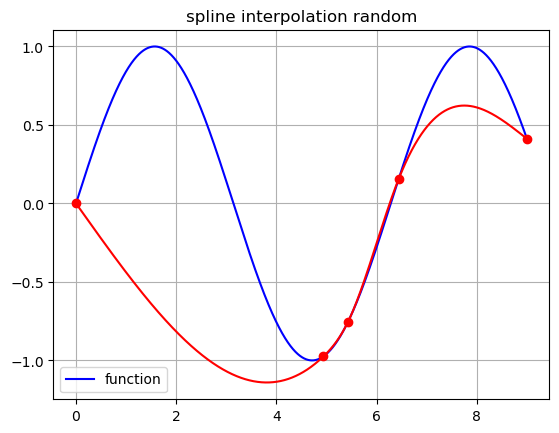

p [0.   2.25 4.5  6.75 9.  ]
h [2.25 2.25 2.25 2.25]
f [ 0.     0.778 -0.978  0.45   0.412]
d [ 0.346 -0.78   0.634 -0.017]
r [-6.756  8.488 -3.908]
matrix
[[9.   2.25 0.  ]
 [2.25 9.   2.25]
 [0.   2.25 9.  ]]
[[9.   9.   9.  ]
 [2.25 2.25 0.  ]]
u [ 0.    -1.105  1.416 -0.788  0.   ] (5,)
a 0.0 - 0.333 x + 0.5 x**2 - 0.167 x**3
b 0.0 - 0.167 x + 0.0 x**2 + 0.167 x**3
1 0.0 + 1.71 x + 0.0 x**2 - 0.932 x**3
2 0.778 - 1.086 x - 2.797 x**2 + 2.127 x**3
3 -0.978 - 0.298 x + 3.585 x**2 - 1.86 x**3
4 0.45 + 1.292 x - 1.995 x**2 + 0.665 x**3


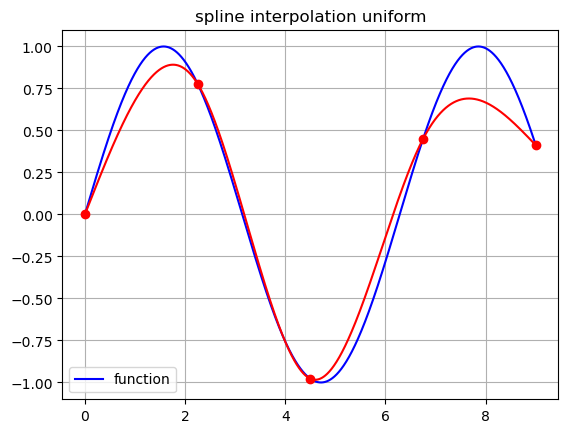

p [0.22  1.855 4.5   7.145 8.78 ]
h [1.635 2.645 2.645 1.635]
f [ 0.218  0.96  -0.978  0.759  0.601]
d [ 0.454 -0.732  0.657 -0.097]
r [-7.116  8.334 -4.519]
matrix
[[ 8.56   2.645  0.   ]
 [ 2.645 10.58   2.645]
 [ 0.     2.645  8.56 ]]
[[ 8.56  10.58   8.56 ]
 [ 2.645  2.645  0.   ]]
u [ 0.    -1.243  1.334 -0.94   0.   ] (5,)
a 0.0 - 0.333 x + 0.5 x**2 - 0.167 x**3
b 0.0 - 0.167 x + 0.0 x**2 + 0.167 x**3
1 0.218 + 1.295 x + 0.0 x**2 - 0.554 x**3
2 0.96 - 0.593 x - 4.35 x**2 + 3.005 x**3
3 -0.978 - 0.277 x + 4.665 x**2 - 2.651 x**3
4 0.759 + 0.679 x - 1.256 x**2 + 0.419 x**3


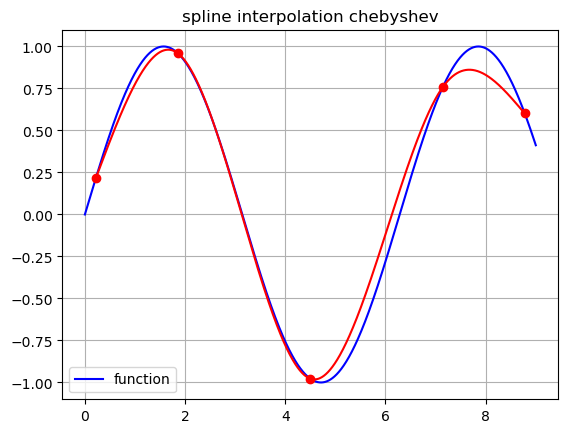

In [146]:
np.random.seed(0)
spline_interpol(4, 0, 9, np.sin, 'random', True)
spline_interpol(4, 0, 9, np.sin, 'uniform', True)
spline_interpol(4, 0, 9, np.sin, 'chebyshev', True)

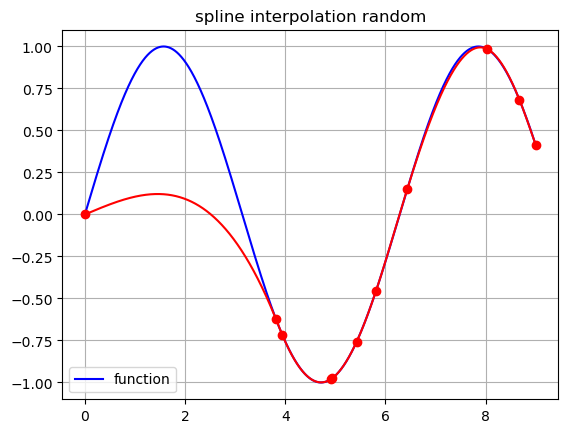

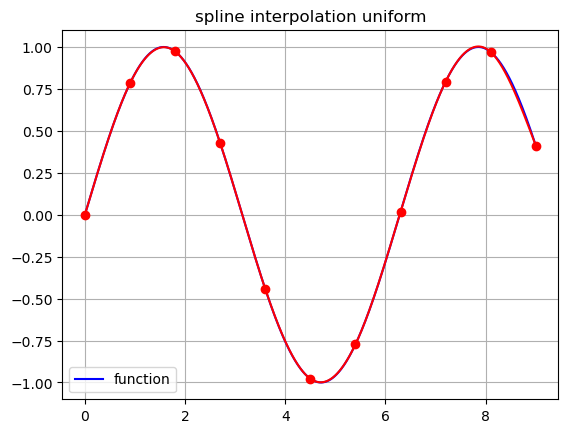

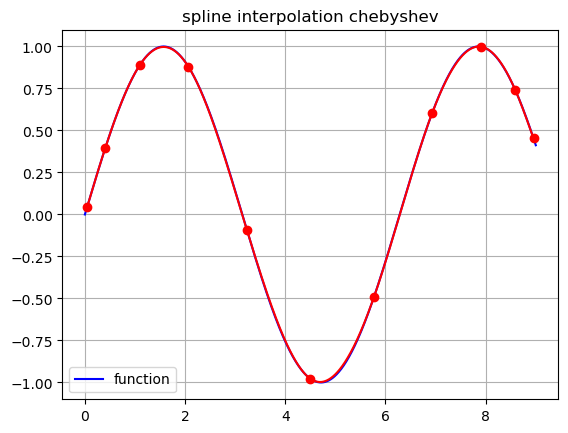

In [147]:
np.random.seed(0)
spline_interpol(10, 0, 9, np.sin, 'random')
spline_interpol(10, 0, 9, np.sin, 'uniform')
spline_interpol(10, 0, 9, np.sin, 'chebyshev')

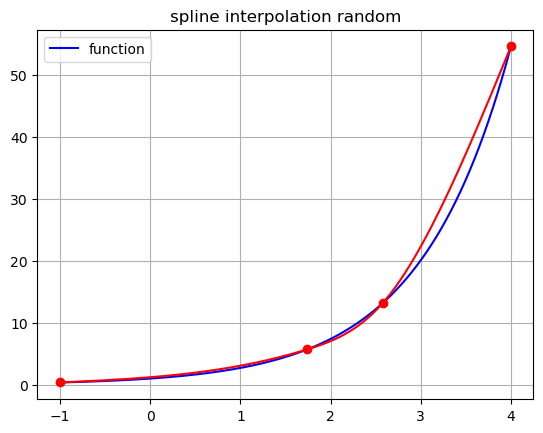

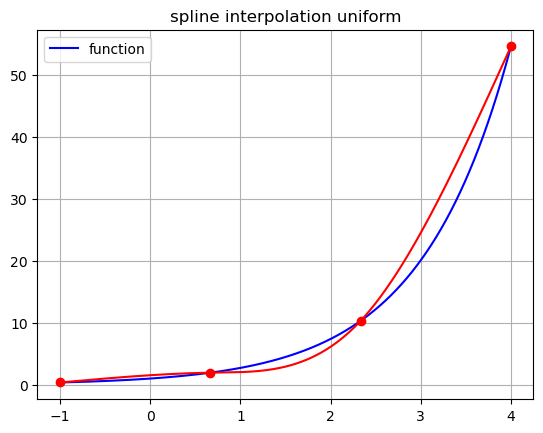

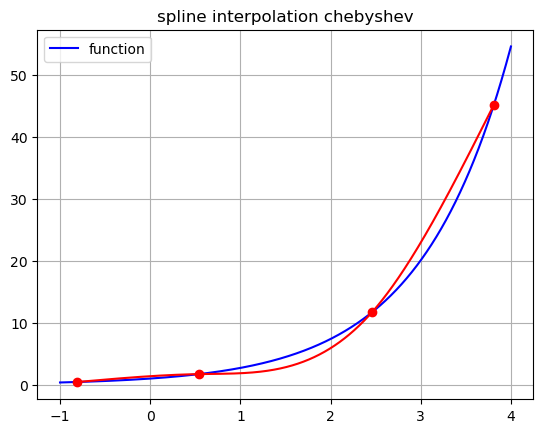

In [148]:
np.random.seed(0)
spline_interpol(3, -1, 4, np.exp, 'random')
spline_interpol(3, -1, 4, np.exp, 'uniform')
spline_interpol(3, -1, 4, np.exp, 'chebyshev')

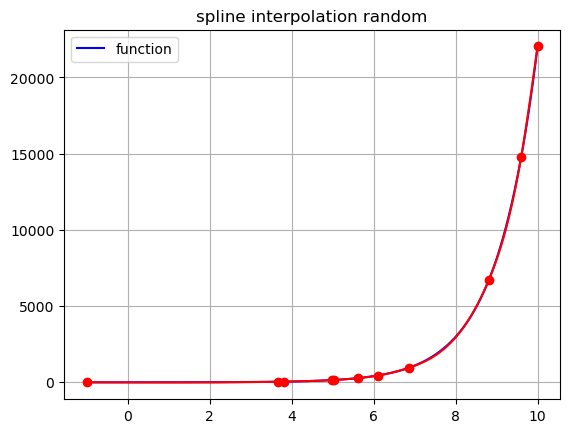

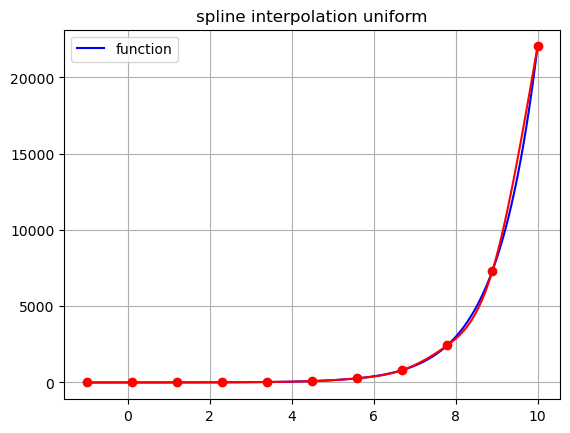

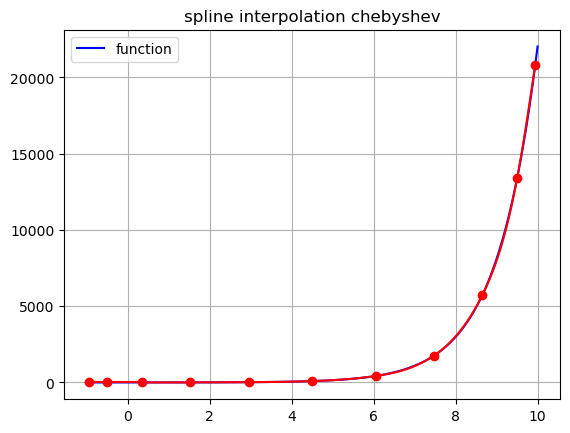

In [154]:
np.random.seed(0)
spline_interpol(10, -1, 10, np.exp, 'random')
spline_interpol(10, -1, 10, np.exp, 'uniform')
spline_interpol(10, -1, 10, np.exp, 'chebyshev')

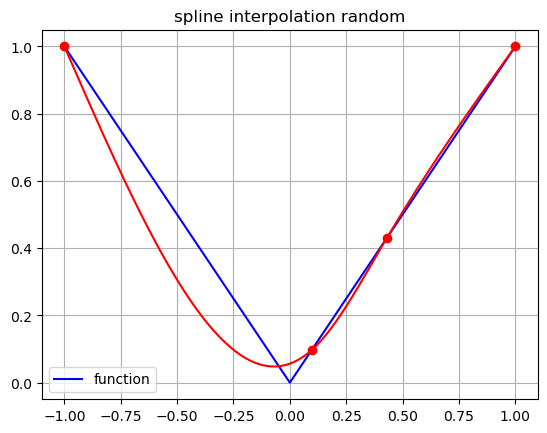

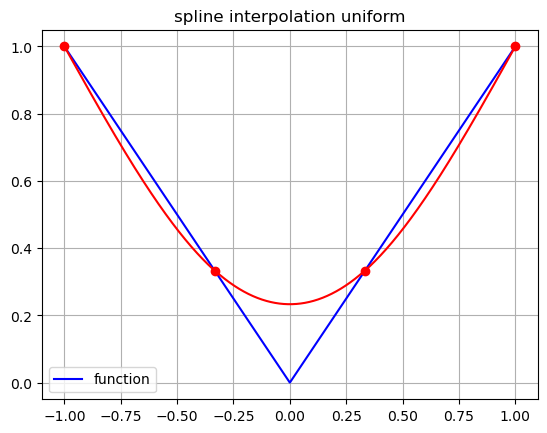

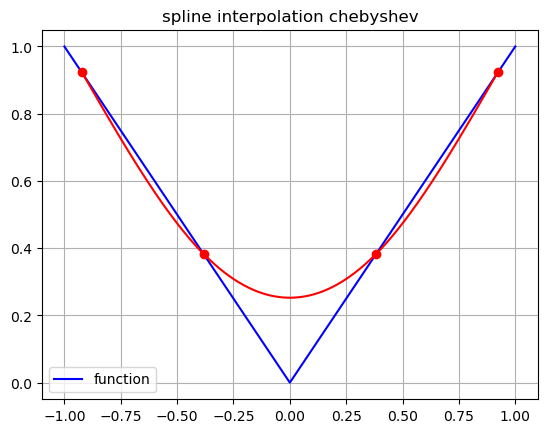

In [149]:
np.random.seed(0)
spline_interpol(3, -1, 1, np.abs, 'random')
spline_interpol(3, -1, 1, np.abs, 'uniform')
spline_interpol(3, -1, 1, np.abs, 'chebyshev')

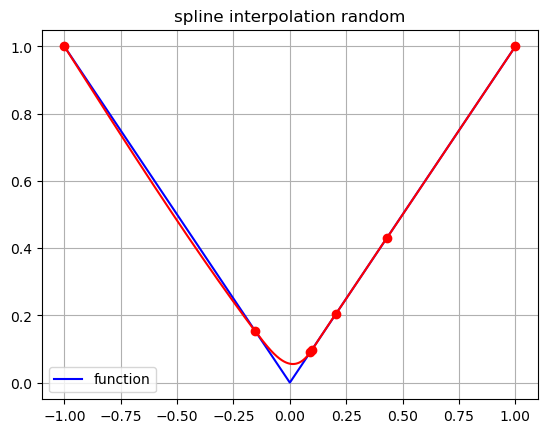

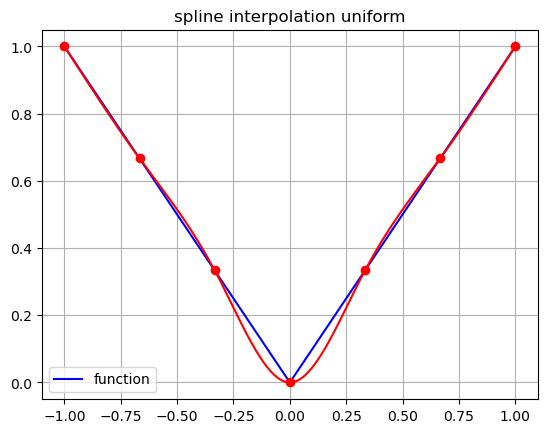

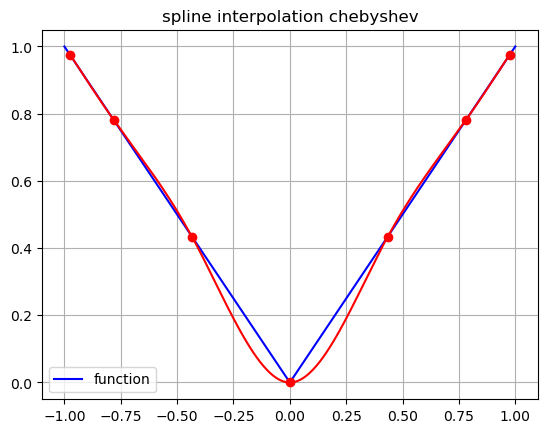

In [150]:
np.random.seed(0)
spline_interpol(6, -1, 1, np.abs, 'random')
spline_interpol(6, -1, 1, np.abs, 'uniform')
spline_interpol(6, -1, 1, np.abs, 'chebyshev')

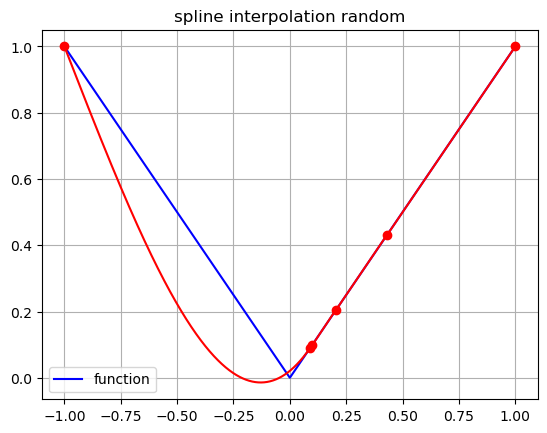

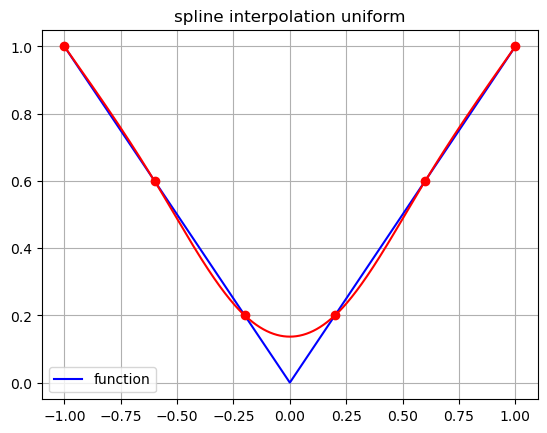

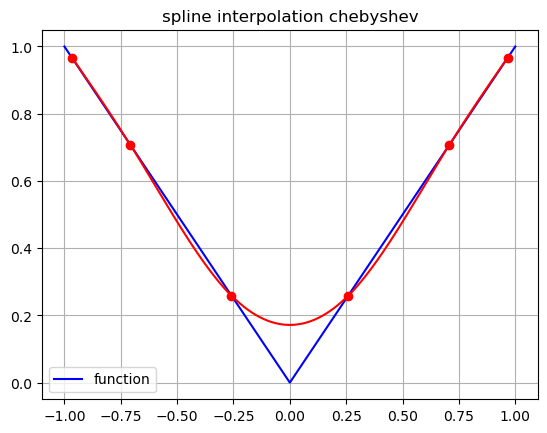

In [151]:
np.random.seed(0)
spline_interpol(5, -1, 1, np.abs, 'random')
spline_interpol(5, -1, 1, np.abs, 'uniform')
spline_interpol(5, -1, 1, np.abs, 'chebyshev')

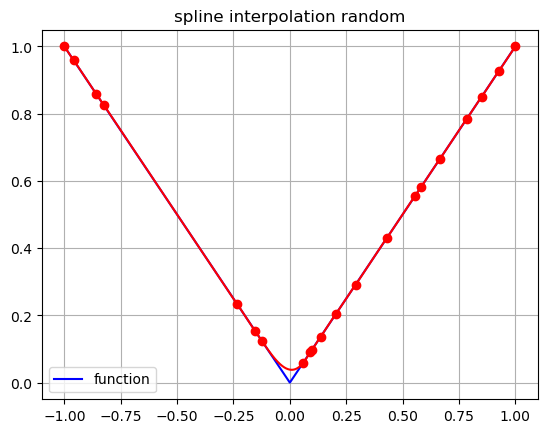

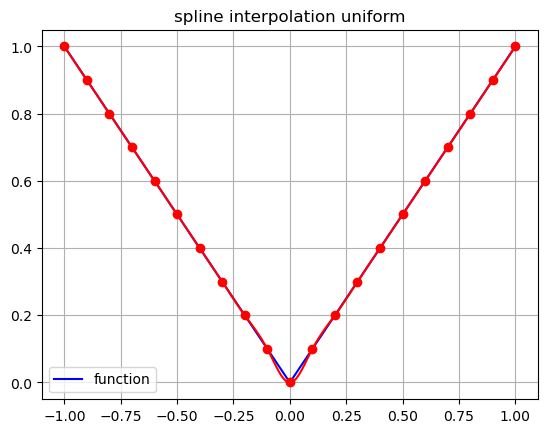

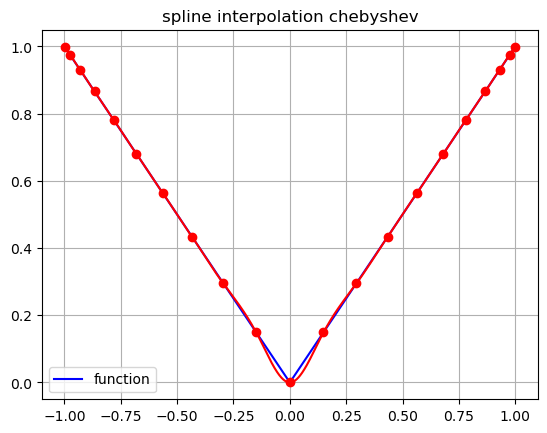

In [152]:
np.random.seed(0)
spline_interpol(20, -1, 1, np.abs, 'random')
spline_interpol(20, -1, 1, np.abs, 'uniform')
spline_interpol(20, -1, 1, np.abs, 'chebyshev')